# Introduction to Maximum Likelihood Estimation

Note: This notebook is adapted from a notebook used in a class by Richard W. Evans (MACS 30100 and MACS 40200).

#### Disc: What is a model?

## 1. General characterization of a model and data generating process

Statistical models are tools to help us summarize complex data. A model usually attempts to be a simplified but useful representation of the world. Mathematically, a statistical model is a probability distribution. From [Wikipedia](https://en.wikipedia.org/wiki/Statistical_model),

> A statistical model is a mathematical model that embodies a set of statistical assumptions concerning the generation of some sample data and similar data from a larger population. A statistical model represents, often in considerably idealized form, the data-generating process.
>
> The assumptions embodied by a statistical model describe a set of probability distributions, some of which are assumed to adequately approximate the distribution from which a particular data set is sampled. The probability distributions inherent in statistical models are what distinguishes statistical models from other, non-statistical, mathematical models.

In general, the procedure of estimating a model involves choosing values of the parameters of a model so that the model matches some number of properties of the data. Estimation procedures can be broadly categorized by the criteria by which they choose these model parameters. For example, Ordinary Least Squares (OLS) refers to a class of estimation procedures that minimizes squared errors. Moment matching procedures (like the Generalized Method of Moments, or GMM) use statistical moments (like the mean) and try to match the model's moments to the moments of the data. Maximum Likelihood, as we will discuss in this lecture, chooses parameters my maximizing a "likelihood function", which can be interpreted as choosing model parameters such that the likelihood of that model producing the given data is maximized.

Define a model or data generating process (DGP) as:

$$ F(X|\theta) = 0 \quad\text{or}\quad F(x_1, x_2,...x_J|\theta) = 0 $$

Note that, in general, a model could also include inequalities representing constraints. But this is sufficient for our discussion. The goal of maximum likelihood estimation (MLE) is to choose the parameter vector of the model $\theta$ to maximize the likelihood of seeing the data produced by the model $(x_1, x_2,... x_J)$. We will define the likelihood of a model shortly.

A simple example of a model is a statistical distribution (e.g., the normal distribution $N(\mu, \sigma)$).

$$ Pr(x|\theta) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left\{-\frac{(x - \mu)^2}{2\sigma^2}\right\} $$

The probability of drawing value $x_i$ from the distribution $f(x|\theta)$ is $f(x_i|\theta)$. The probability of drawing the following vector of two observations $(x_1,x_2)$ from the distribution $f(x|\theta)$ is $f(x_1|\theta)\times f(x_2|\theta)$. We define the likelihood function of $N$ draws $(x_1,x_2,...x_N)$ from a model or distribution $f(x|\theta)$ as $\mathcal{L}$.

$$ \mathcal{L}(x_1,x_2,...x_N|\theta) \equiv \prod_{i=1}^N f(x_i|\theta) $$

Because it can be numerically difficult to maximize a product of percentages (one small value can make dominate the entire product), it is almost always easier to use the log likelihood function $\ln(\mathcal{L})$.

$$ \ln\Bigl(\mathcal{L}(x_1,x_2,...x_N|\theta)\Bigr) \equiv \sum_{i=1}^N \ln\Bigl(f(x_i|\theta)\Bigr) $$

The maximum likelihood estimate $\hat{\theta}_{MLE}$ is the following:

$$ \hat{\theta}_{MLE} = \arg \max_\theta \:  \ln\mathcal{L}(x_1,x_2,...x_N|\theta). $$

A more complicated example of an economic model that follows the more general definition of $F(X|\theta) = 0$ above would be something like the macroeconomic model of Brock and Mirman (1972). This model has multiple nonlinear dynamic equations, 7 parameters, 1 exogenous time series of variables, and about 5 endogenous time series of variables.

Note: MLE is an important tool for structural estimation.

## 2. Comparisons of distributions and data

Import some data from the total points earned by all the students in two sections of an intermediate macroeconomics class (anonymized data).

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
# Comment this out if the package is unavailable.
import ipywidgets
# You can install this by running the following in your terminal
# conda install -c conda-forge ipywidgets

#### Let's Create a Custom Data Generating Process

This will simulate test scores in a class. I want there to be an upper and lower limit to the scores that can be obtained. I also want there to be something close to a Normal distribution of scores. I will use a truncated Normal distribution. (Other distributions, like a Beta distribution, could potentially be better.)

In [3]:
def gen_data(mu=0, sigma=1, lower_lim=0, upper_lim=1000, n=200):
    data = np.zeros(n)
    for i in range(n):
        redo = True
        while redo:
            draw = np.random.normal(loc=mu, scale=sigma)
            if draw > lower_lim and draw < upper_lim:
                redo = False
        data[i] = draw
    return data

In [4]:
np.random.seed(100)
mu_true = 380
sigma_true = 55
pts = gen_data(mu=mu_true, sigma=sigma_true, lower_lim=0, upper_lim=450)
pts = pd.Series(pts)

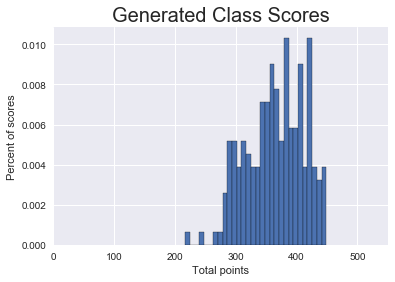

In [5]:
# count, bins, ignored = plt.hist(pts, 30, edgecolor='black', normed=True)
count, bins, ignored = plt.hist(pts, bins=30, edgecolor='black', density=True)
plt.title('Generated Class Scores', fontsize=20)
plt.xlabel('Total points')
plt.ylabel('Percent of scores')
plt.xlim([0, 550]);  # This gives the xmin and xmax to be plotted"
# Don't set this figure until have played with the figure below

#### Disc: What is the PDF of the process that we created above?

In [6]:
# Define function that generates values of a potentially trucated normal
# probability density function (PDF)
def truncnorm_pdf(xvals, mu=300, sigma=100, cutoff=None):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

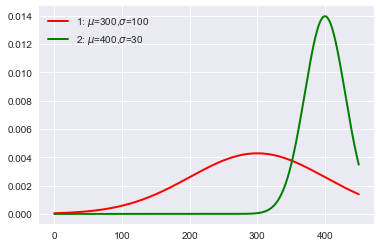

In [7]:
dist_pts = np.linspace(0, 450, 500)
mu_1 = 300
sig_1 = 100
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, cutoff=450),
         linewidth=2, color='r', label='1: $\mu$=300,$\sigma$=100')
plt.legend(loc='upper left')

mu_2 = 400
sig_2 = 30
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_2, sig_2, cutoff=450),
         linewidth=2, color='g', label='2: $\mu$=400,$\sigma$=30')
plt.legend(loc='upper left')

#### Disc: How do the parameters affect the distribution we created?

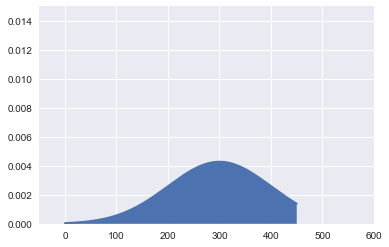

In [8]:
def f(mu = 300, sigma=100, truncation = 450):
    mu_1 = mu
    sig_1 = sigma
    fig, ax = plt.subplots()
    X = dist_pts
    Y = truncnorm_pdf(dist_pts, mu_1, sig_1, truncation)
    plt.plot(X, Y, linewidth=2)
    plt.xlim(-50,600)
    plt.ylim(0,0.015)
    ax.fill_between(X, Y)
    
f()

In [9]:
ipywidgets.interact(f)

interactive(children=(IntSlider(value=300, description='mu', max=900, min=-300), IntSlider(value=100, descript…

<function __main__.f(mu=300, sigma=100, truncation=450)>

#### Disc: Which distribution (1 or 2, replicated below) will have the biggest log likelihood function? Why?

Let's compute the log likelihood function for this data for both of these distributions.

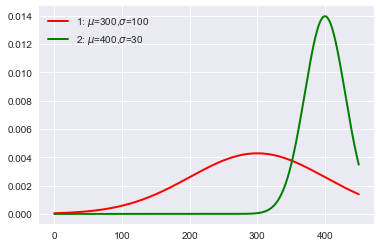

In [10]:
dist_pts = np.linspace(0, 450, 500)
mu_1 = 300
sig_1 = 100
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, cutoff=450),
         linewidth=2, color='r', label='1: $\mu$=300,$\sigma$=100')
plt.legend(loc='upper left')

mu_2 = 400
sig_2 = 30
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_2, sig_2, cutoff=450),
         linewidth=2, color='g', label='2: $\mu$=400,$\sigma$=30')
plt.legend(loc='upper left')

In [11]:
# Define log likelihood function for the normal distribution
def log_lik_truncnorm(xvals, mu, sigma, cutoff):
    pdf_vals = truncnorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood 1: ', log_lik_truncnorm(pts, mu_1, sig_1, 450))
print('Log-likelihood 2: ', log_lik_truncnorm(pts, mu_2, sig_2, 450))

Log-likelihood 1:  -1155.637754146585
Log-likelihood 2:  -1230.8944596709596


#### Disc: Why is the log likelihood value negative?

In [12]:
np.log(.001)

-6.907755278982137

In [13]:
truncnorm_pdf(pts[0], mu_1, sig_1, cutoff=450)

0.004225152806194555

In [14]:
np.log(truncnorm_pdf(pts[0], mu_1, sig_1, cutoff=450))

-5.466699851680375

How do we estimate $\mu$ and $\sigma$ by maximum likelihood? What values of $\mu$ and $\sigma$ will maximize the likelihood function?
$$(\hat{\mu},\hat{\sigma})_{MLE} = (\mu, \sigma):\quad argmax_{\mu,\sigma}\:\mathcal{L}=\sum_{i=1}^N\ln\Bigl(f(x_i|\mu,\sigma)\Bigr)$$

## 3. How to set up a maximization (minimization) problem in Python (*Review*)
A minimizer is a function that chooses a single value or a vector of values to minimize the result of a scalar-valued function of that vector. Any maximization problem can be restated as a minimization problem. Because minimization problems are more numerically stable and well defined, most numerical optimizers are stated as minimizers. The [scipy.optimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html) library has many types of root-finders and minimizers. For our maximum likelihood estimation problems, we will use the [scipy.optimize.minimize()](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function.

### 3.1. The criterion function
The first step is to write a function that takes two inputs and returns a scalar value.
1. The first input is either a scalar or a vector of values (the object `params` in the function `crit()` below). This object is the value or values being chosen to minimize the criterion function.
2. The second object is Python's variable length input objects `*args`, which is a tuple of variable length positional arguments. As you will see in the `minimize()` function, all the arguments must be passed into the criterion function in one tuple.
3. Lastly, you must make sure that the scalar criterion value that the function returns is the value of the problem stated as a minimization problem and not a maximization problem. In this case of maximum likelihood estimation, you want the negative of the log likelihood function.

In [15]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [16]:
def nll_print(mu=100.0, sigma=100.0):
    params = np.array([mu, sigma])
    xvals = pts
    cutoff = 450.0
    neg_log_lik_val = crit(params, xvals, cutoff)
    print('Negative Log-Likelihood: ', neg_log_lik_val)

In [17]:
nll_print()

Negative Log-Likelihood:  1797.2193043411141


In [18]:
ipywidgets.interact(nll_print, mu=(1,1000), sigma=(1,1000))

interactive(children=(IntSlider(value=100, description='mu', max=1000, min=1), IntSlider(value=100, descriptio…

<function __main__.nll_print(mu=100.0, sigma=100.0)>

In [19]:
def vis_MLE(mu=380, sigma=55):
    # Plot the histogram of the data
    count, bins, ignored = plt.hist(pts, 30, edgecolor='black', density=True)
    plt.title('Econ 381 scores: 2011-2012', fontsize=20)
    plt.xlabel('Total points')
    plt.ylabel('Percent of scores')
    

    # Plot the two test distributions from before
    plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, 450),
             linewidth=2, color='r', label='1: $\mu$=300,$\sigma$=30')
    plt.legend(loc='upper left')

    plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_2, sig_2, 450),
             linewidth=2, color='g', label='2: $\mu$=400,$\sigma$=70')
    plt.legend(loc='upper left')

    # Plot the MLE estimated distribution
    plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu, sigma, 450),
             linewidth=2, color='k', label='3: Custom')
    plt.legend(loc='upper left')
    plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"
    plt.ylim([0,0.03])

In [20]:
ipywidgets.interact(vis_MLE, sigma=(1, 300))

interactive(children=(IntSlider(value=380, description='mu', max=1140, min=-380), IntSlider(value=55, descript…

<function __main__.vis_MLE(mu=380, sigma=55)>

#### Disc: Using this picture, why do we say we are maximizing likilihood? Could we say that we are maximixing the *probability* of observing the data given the parameters?

(Given our modelling assumptions, the probability of any of these observations occuring is zero.)

### 3.2. The minimize() function
The `minimize()` function is shorthand for `scipy.optimize.minimize()`. This function returns a dictionary of objects including the solution to the optimization problem and whether the problem actually solved. The `minimize` function has three mandatory arguments, plus a lot of options. You can experiment with the options on the [`minimize()` documentation page](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).
1. The first argument of the minimize function is the criterion function (`crit()` in this example) from which the `minimize()` function will test values of the parameters in searching for the minimum value.
2. The second argument is an initial guess for the values of the parameters that minimize the criterion function `crit()`.
3. The third argument is the tuple of all the objects needed to solve the criterion function in `crit()`.

In [21]:
import scipy.optimize as opt

mu_init = 380  # mu_2
sig_init = 55  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 450.0)
results = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 374.6473109671005  sig_MLE= 54.51802543075607


In [22]:
mu_MLE

374.6473109671005

In [23]:
mu_true

380

In [24]:
sigma_true

55

In [25]:
results

      fun: 1042.9174358846615
 hess_inv: array([[26.16825456,  9.61730282],
       [ 9.61730282, 15.06923742]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([374.64731097,  54.51802543])

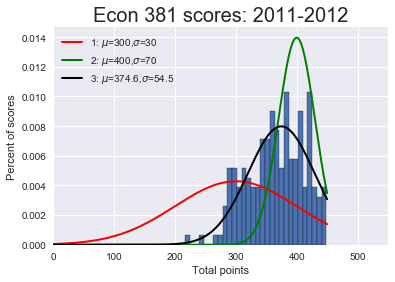

In [26]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts, 30, edgecolor='black', density=True)
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel('Total points')
plt.ylabel('Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

# Plot the two test distributions from before
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, 450),
         linewidth=2, color='r', label='1: $\mu$=300,$\sigma$=30')
plt.legend(loc='upper left')

plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_2, sig_2, 450),
         linewidth=2, color='g', label='2: $\mu$=400,$\sigma$=70')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_MLE, sig_MLE, 450),
         linewidth=2, color='k', label=f'3: $\mu$={mu_MLE:.1f},$\sigma$={sig_MLE:3.1f}')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

In [27]:
print('Log-likelihood 1: ', log_lik_truncnorm(pts, mu_1, sig_1, 450))
print('Log-likelihood 2: ', log_lik_truncnorm(pts, mu_2, sig_2, 450))
print('MLE log-likelihood 3: ', log_lik_truncnorm(pts, mu_MLE, sig_MLE, 450))

Log-likelihood 1:  -1155.637754146585
Log-likelihood 2:  -1230.8944596709596
MLE log-likelihood 3:  -1042.9174358846615


Let's see if this likelihood function is well behaved by looking at a grid over possible values of $\mu$ and $\sigma$ for the given data.

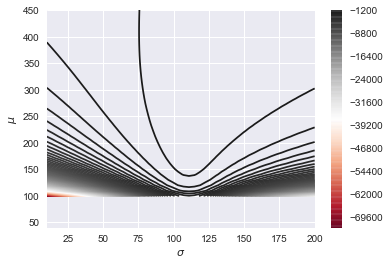

In [28]:
fineness = 50
mu_vals = np.linspace(100, 600, fineness)
sig_vals = np.linspace(10, 200, fineness)
lnlik_vals = np.zeros((fineness, fineness))
for mu_ind in range(fineness):
    for sig_ind in range(fineness):
        lnlik_vals[mu_ind, sig_ind] = log_lik_truncnorm(pts, mu_vals[mu_ind],
                                                        sig_vals[sig_ind], 450)
        

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
plt.contour(sig_mesh, mu_mesh, lnlik_vals, 200, cmap='RdGy')
plt.ylim(40,450)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.colorbar();

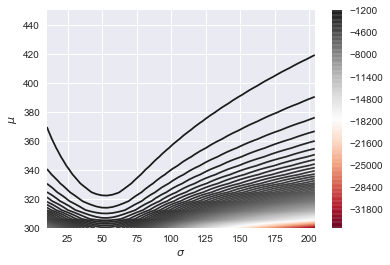

In [29]:
fineness = 50
mu_vals = np.linspace(300, 600, fineness)
sig_vals = np.linspace(10, 204, fineness)
lnlik_vals = np.zeros((fineness, fineness))
for mu_ind in range(fineness):
    for sig_ind in range(fineness):
        lnlik_vals[mu_ind, sig_ind] = log_lik_truncnorm(pts, mu_vals[mu_ind],
                                                        sig_vals[sig_ind], 450)
        

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
plt.contour(sig_mesh, mu_mesh, lnlik_vals, 200, cmap='RdGy')
plt.ylim(300,450)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.colorbar();

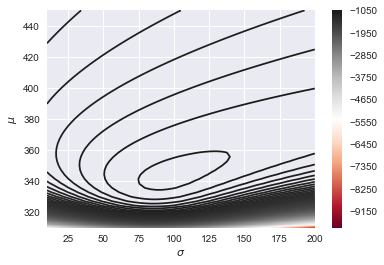

In [30]:
fineness = 50
mu_vals = np.linspace(310, 450, fineness)
sig_vals = np.linspace(10, 200, fineness)
lnlik_vals = np.zeros((fineness, fineness))
for mu_ind in range(fineness):
    for sig_ind in range(fineness):
        lnlik_vals[mu_ind, sig_ind] = log_lik_truncnorm(pts, mu_vals[mu_ind],
                                                        sig_vals[sig_ind], 450)
        

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
plt.contour(sig_mesh, mu_mesh, lnlik_vals, 400, cmap='RdGy')
# plt.ylim(40,450)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.colorbar();

In [31]:
# %matplotlib notebook

Text(0.5,0,'log likelihood')

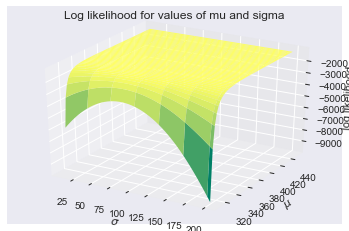

In [32]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

fineness = 50
mu_vals = np.linspace(310, 450, fineness)
sig_vals = np.linspace(10, 200, fineness)
lnlik_vals = np.zeros((fineness, fineness))
for mu_ind in range(fineness):
    for sig_ind in range(fineness):
        lnlik_vals[mu_ind, sig_ind] = log_lik_truncnorm(pts, mu_vals[mu_ind],
                                                        sig_vals[sig_ind], 450)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, lnlik_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Log likelihood for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'log likelihood')

### Try this again with the Real Data

We will try this again with the real data. The real data isn't as well behaved as the 

In [33]:
pts_real = np.loadtxt('Econ381totpts.txt')
pts_real = pd.Series(pts_real)

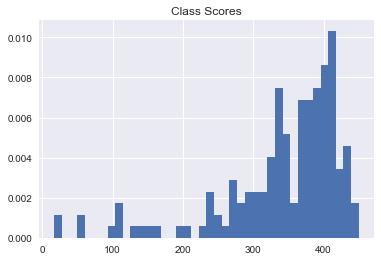

In [34]:
pts_real.hist(density=True, bins=40)
plt.title('Class Scores');

#### Let's perform the optimization routine again on this new data

In [35]:
mu_init = 380  # mu_2
sig_init = 55  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (pts_real, 450.0)
results_real = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE_real, sig_MLE_real = results_real.x
print('mu_MLE=', mu_MLE_real, ' sig_MLE=', sig_MLE_real)

mu_MLE= 622.1198752801231  sig_MLE= 198.74400093931376


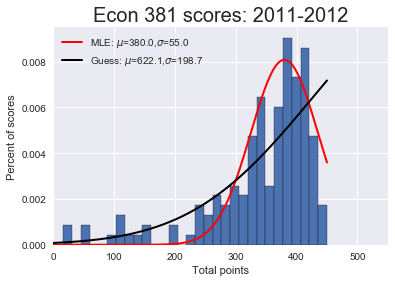

In [36]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts_real, 30, edgecolor='black', density=True)
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel('Total points')
plt.ylabel('Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

mu_guess = 380
sig_guess = 55
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_guess, sig_guess, 450),
         linewidth=2, color='r', label=f'MLE: $\mu$={mu_guess:.1f},$\sigma$={sig_guess:3.1f}')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_MLE_real, sig_MLE_real, 450),
         linewidth=2, color='k', label=f'Guess: $\mu$={mu_MLE_real:.1f},$\sigma$={sig_MLE_real:3.1f}')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

#### Disc: How well does this fit? How does the MLE estimate compare to the guess given above?

How does the fit compare to this guess below?
```python
mu_guess = 380
sig_guess = 55
```
Why does MLE give the fit that it does rather than something closer to what our guess is?

### 3.3. Constrained minimization using the minimize() function
The [`minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function has many methods that can be used to find the parameter values that minimize some criterion function. These methods are called using the `method='MethodName'` optional input argument to the minimize function. Three of those methods allow for constrained minimization by providing upper and lower bounds for the parameters being chosen. These three methods are `'L-BFGS-B'`, `'TNC'`, and `'SLSQP'`.

Suppose you were trying to estimate $\mu$ and $\sigma$ of a truncated normal distribution as is the case above. The value of $\mu$ need not be constrained. However, the value of $\sigma$ must be strictly positive. You could include these bounds in a constrained minimization by using the following code.

Note that you must set the lower bound of $\sigma$ equal to some small positive number close to zero. You cannot set it to zero itself because the bounds are inclusive. That is, the minimizer might try a value of $\sigma=0$ is the lower bound includes zero.

In [37]:
mle_args = (pts_real, 450.0)
results_con = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((1e-10, 420.0), (1e-10, None)))
results_con

      fun: 913.1743336858821
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.99925443e-02,  1.13686838e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 12
   status: 0
  success: True
        x: array([420.        , 129.04020805])

In [38]:
mu_con, sig_con = results_con.x

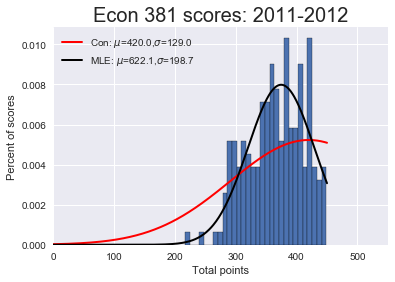

In [39]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts, 30, edgecolor='black', density=True)
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel('Total points')
plt.ylabel('Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_con, sig_con, 450),
         linewidth=2, color='r', label=f'Con: $\mu$={mu_con:.1f},$\sigma$={sig_con:3.1f}')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_MLE, sig_MLE, 450),
         linewidth=2, color='k', label=f'MLE: $\mu$={mu_MLE_real:.1f},$\sigma$={sig_MLE_real:3.1f}')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

In [40]:
print('Log-likelihood Constrained: ', log_lik_truncnorm(pts_real, mu_con, sig_con, 450))
print('Log-likelihood Guess: ', log_lik_truncnorm(pts_real, mu_guess, sig_guess, 450))
print('Log-likelihood MLE Uncon: ', log_lik_truncnorm(pts_real, mu_MLE, sig_MLE, 450))

Log-likelihood Constrained:  -913.1743336858821
Log-likelihood Guess:  -1022.8151477937042
Log-likelihood MLE Uncon:  -1018.7255220758334


## 4. The variance-covariance matrix of ML estimates
Davidson and MacKinnon (2004, Sec. 10.4) have a great discussion four different estimators for the variance-covariance matrix of the maximum likelihood estimates. That is, we want to know what is the variance or uncertainty of our estimates for $\mu$ and $\sigma$, and how are those two estimates correlated. The four most common estimators for the VCV matrix of a maximum likelihood estimate are:
1. Empirical Hessian estimator (H)
2. Information matrix estimator (I)
3. Outer-product-of-the-gradient estimator (OPG)
4. Sandwich estimator (S)

All of these estimators of the VCV matrix intuitively measure how flat the likelihood function is at the estimated parameter values in the dimension of each estimated parameter. The Hessian is a matrix of second derivatives of the log likelihood function with respect to the parameters being chosen. The Hessian matrix therefore captures information about how the slope of the log likelihood function is changing in each direction. The empirical Hessian estimator is the most commonly used. One really nice property of Python's `minimize()` function is that one of the result objects is the inverse Hessian.

$$ \hat{VCV}_H(\hat{\theta}) =-H^{-1}(\hat{\theta}) \quad\text{from max prob} $$

Note that this expression is for the maximum likelihood problem posed as a maximization problem of the log likelihood function. We are transforming it into a minimization problem of the negative of the log likelihood function. Let the operator $OffDiag(-1)$ change the sign of each off diagonal element. Then the estimator of the variance covariance matrix from the minimization problem is:

$$ \hat{VCV}_H(\hat(\theta)) = OffDiag(-1) H^{-1}(\hat{\theta}) \quad\text{from min prob} $$

In [41]:
results

      fun: 1042.9174358846615
 hess_inv: array([[26.16825456,  9.61730282],
       [ 9.61730282, 15.06923742]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([374.64731097,  54.51802543])

In [42]:
# Note that here we are using our simulated data again
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[26.16825456 -9.61730282]
 [-9.61730282 15.06923742]]
Standard error for mu estimate =  5.115491624894846
Standard error for sigma estimate =  3.8819115676214584


### Using `statsmodels` to estimate MLE

Here we can create a custom model class. Complicated and opaque...

In [43]:
from statsmodels.base.model import GenericLikelihoodModel

In [44]:
class TruncatedNormal(GenericLikelihoodModel):
    def __init__(self, exog, **kwds):
        super(TruncatedNormal, self).__init__(exog, exog, **kwds)

    def nloglikeobs(self, params):
        mu = params[0]
        sigma = params[1]
        cutoff = 450
        log_lik_val = log_lik_truncnorm(self.exog, mu, sigma, cutoff)
        return -log_lik_val

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names[0] = 'mu'
        self.exog_names.append('sigma')
        if start_params == None:
            start_params = [100, 30]
        return super(TruncatedNormal, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

In [45]:
mod = TruncatedNormal(pts)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 5.214587
         Iterations: 66
         Function evaluations: 127


In [46]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           TruncatedNormal Results                            
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -1042.9
Model:                TruncatedNormal   AIC:                             2088.
Method:            Maximum Likelihood   BIC:                             2091.
Date:                Thu, 03 May 2018                                         
Time:                        14:16:32                                         
No. Observations:                 200                                         
Df Residuals:                     199                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mu           374.6473      5.331     70.281      0.000     364.199     385.095
sigma         54.5181      4.066     13.408      0.000      46.549      62.487
==============================================================================
"""

In [47]:
mu_true

380

In [48]:
sigma_true

55

## 5. Hypothesis testing
Can we reject the hypothesis that $\mu=400$ and $\sigma=70$ with 95% confidence? How do you answer that question? What does the figure tell us about this answer? In this section, we will discuss four ways to perform hypothesis testing.
1. Two standard errors (back of the envelope, approximation)
2. Likelihood ratio test
3. Wald test
4. Lagrange multiplier test

Davidson and MacKinnon (2004, Sec. 10.5) have a more detailed discussion of methods 2, 3, and 4.

### 5.1. Back of the envelope, two standard errors (assuming normality)
A really quick approach to hypothesis testing is to see if your hypothesized values are within two standard errors of the estimated values. This approach is not completely correct because estimates in the log likelihood function are not symmetrically distributed. But it is at least a first approximation. 

In [49]:
lb_mu_95pctci = mu_MLE - 2 * stderr_mu_mle
print('mu_MLE=', mu_MLE, ', lower bound 95% conf. int.=', lb_mu_95pctci)

lb_sig_95pctci = sig_MLE - 2 * stderr_sig_mle
print('sig_MLE=', sig_MLE, ', lower bound 95% conf. int.=', lb_sig_95pctci)

mu_MLE= 374.6473109671005 , lower bound 95% conf. int.= 364.4163277173108
sig_MLE= 54.51802543075607 , lower bound 95% conf. int.= 46.75420229551315


### 5.2. Likelihood ratio test
The likelihood ratio test is the simplest and, therefore, the most common of the three more precise methods (2, 3, and 4). Let your maximum likelihood estimation have $d$ parameters (the vector $\theta$ has $d$ elements), let $\hat{\theta}_{MLE}$ be the maximum likelihood estimate, and let $\tilde{\theta}$ be your hypothesized values of the parameters (a null-hypothesis). $\tilde \theta$ is the "constrained model," where we have constrained the parameters to match those of our our null-hypothesis. (Note that we don't need to constrain all the parameters, but we will in our example.) The likelihood ratio test statistic is the following.

$$ LR(\tilde{\theta}|\hat{\theta}_{MLE}) = 2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(d) $$

#### Disc: What is the support of a chi-squared distribution? Are we sure that LR will always be non-negative?
#### Disc: If the null-hypothesis were true, what would we expect the difference of the likelihoods to be?

In our example, we have assumed a null-hypothesis of $\mu = 400$ and $\sigma = 70$. Thus, we have constrained both parameters.
Thus, this is a joint test of the likelihood of $H_0: \mu_0, \sigma_0$. 

The value of the $\chi^2(d)$ has the following interpretation. (Take a look at the shape of a [Chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) here.)
The area under the $\chi^2(d)$ pdf from $LR$ and above is the significance level or $p$-value. It represents the probability, under null hypothesis $\tilde{\theta}$, that the data produces an MLE estimate $\hat{\theta}_{MLE}$ that is more extreme than the one that we actually observed. More precisely, it represents the probability of drawing data under the null hypothesis produces an LR test statistic greater than or equal to the LR statistic that we actually drew. When this $p$-value is small, it it unlikely that the null hypothesis is true. You can calculate the significance level by taking one minus the cdf of $\chi^2(d)$ at the $LR$ value.

In [50]:
mu_true

380

In [51]:
sigma_true

55

In [52]:
log_lik_h0 = log_lik_truncnorm(pts, 500, 180, 450)
log_lik_mle = log_lik_truncnorm(pts, mu_MLE, sig_MLE, 450)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


In [53]:
log_lik_h0 = log_lik_truncnorm(pts, 385, 55, 450)
log_lik_mle = log_lik_truncnorm(pts, mu_MLE, sig_MLE, 450)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.09216332978995767


## 6. Linear regression with MLE
Although linear regression is most often performed using the ordinary least squares (OLS) estimator, which is a particular type of generalized method of moments (GMM) estimator, this can also be done using MLE. A simple regression specification in which the dependent variable $y_i$ is a linear function of two independent variables $x_{1,i}$ and $x_{2,i}$ is the following:

$$ y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \varepsilon_i \quad\text{where}\quad \varepsilon_i\sim N\left(0,\sigma^2\right) $$

If we solve this regression equation for the error term $\varepsilon_i$, we can start to see how we might estimate the parameters of the model by maximum likelihood.

$$ \varepsilon_i = y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i} \sim N\left(0,\sigma^2\right) $$

The parameters of the regression model are $(\beta_0, \beta_1, \beta_2, \sigma)$. Given some data $(y_i, x_{1,i}, x_{2,i})$ and given some parameter values $(\beta_0, \beta_1, \beta_2, \sigma)$, we could plot a histogram of the distribution of those error terms. And we could compare that empirical histogram to the assumed histogram of the distribution of the errors $N(0,\sigma^2)$. ML estimation of this regression equation is to choose the paramters $(\beta_0, \beta_1, \beta_2, \sigma)$ to make that empirical distribution of errors $\varepsilon_i$ most closely match the assumed distribution of errors $N(0,\sigma^2)$.

## 8. References
* Brock, William A. and Leonard J. Mirman, "Optimal Economic Growth and Uncertainty: The Discounted Case," *Journal of Economic Theory*, 4:3, pp. 479-513 (June 1972).
* Davidson, Russell and James G. MacKinnon, *Econometric Theory and Methods*, Oxford University Press (2004).